In [7]:
import numpy as np
import pandas as pd
import os
from matplotlib import gridspec
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, Flatten, Dense, Reshape, BatchNormalization, Activation
from tensorflow.keras.models import Model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [9]:
def averaged_by_N_rows(a, n):
    """
    A function that averages n rows in a matrix
    """
    shape = a.shape
    assert len(shape) == 2
    assert shape[0] % n == 0
    b = a.reshape(shape[0] // n, n,
                  shape[1])
    mean_vec = b.mean(axis=1)
    return mean_vec

In [10]:
!pip install mne


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [11]:
import pandas as pd
import numpy as np
import mne
from glob import glob
from sklearn.preprocessing import StandardScaler

# Load column labels
col_names = pd.read_csv('./data/columnLabels.csv')
ch_names = list(col_names.columns[4:])

# Define channel types
ch_type = ['eeg'] * 64 + ['eog'] * 4 + ['misc'] + ['eeg']

# Sampling rate
sfreq = 1024

# Read EEG standard montage
montage = mne.channels.make_standard_montage('standard_1005')

# Initialize required fields
info = mne.create_info(ch_names, sfreq, ch_type)
info.set_montage(montage)

# Load demographics and create diagnosis dictionary
demographics = pd.read_csv('./data/demographic.csv')
diagnosis_dict = dict(zip(demographics.subject, demographics[" group"]))

def create_mne_epoch_object(fname, info):
    """Create an MNE Epochs object from a CSV file."""
    info['description'] = 'dataset from ' + fname
    tmin = -1.5
    data = pd.read_csv(fname, header=None)
    npdata = np.array(data)
    onsets = np.array(np.where(npdata[:, 3] == 1537))
    conditions = npdata[npdata[:, 3] == 1537, 2]
    events = np.squeeze(np.dstack((onsets.flatten(), np.zeros(conditions.shape), conditions)))
    EEGdata = npdata.reshape(len(conditions), 3072, 74)
    EEGdata = EEGdata[:, :, 4:]  # Skip the first 4 columns (assuming they are non-EEG)
    EEGdata = np.swapaxes(EEGdata, 1, 2)
    event_id = dict(button_tone=1, playback_tone=2, button_alone=3)
    custom_epochs = mne.EpochsArray(EEGdata, info=info, events=events.astype('int'), tmin=tmin, event_id=event_id)

    # Select only the EEG channels
    picks_eeg = mne.pick_types(custom_epochs.info, eeg=True, eog=False, misc=False)
    custom_epochs = custom_epochs.pick(picks_eeg)

    return custom_epochs

# Process and analyze data for each subject
subjects = range(1, 30)
X = []
y = []

for subject in subjects:
    fnames = glob("./data/%d.csv" % subject)
    if not fnames:
        print(f"No file found for subject {subject}")
        continue
    fname = fnames[0]  # Access the first element of the list
    print(f"Processing file: {fname}")
    custom_epochs = create_mne_epoch_object(fname, info)
    print(custom_epochs)
    picks = mne.pick_types(custom_epochs.info, eeg=True)
    custom_epochs.filter(2, 45, picks=picks, method='iir', n_jobs=-1, verbose=False)

    # Assign the label based on the demographics file
    y.extend([diagnosis_dict[subject]] * len(custom_epochs))

    X.append(custom_epochs.crop(tmin=-0.7, tmax=0.299).get_data())

if not X:
    raise ValueError("No data found. Please check your file paths and ensure data files are available.")

X = np.concatenate(X)
y = np.array(y)

# Standardize the data
scaler = StandardScaler()
n_epochs, n_channels, n_times = X.shape
X = X.reshape(n_epochs, -1)
X = scaler.fit_transform(X)
X = X.reshape(n_epochs, n_channels, n_times)  # Keep n_channels as it is after filtering for EEG
X.shape

Processing file: ./data/1.csv
Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated
<EpochsArray | 289 events (all good), -1.5 – 1.499 s (baseline off), ~440.3 MB, data loaded,
 'button_tone': 100
 'playback_tone': 94
 'button_alone': 95>
Processing file: ./data/2.csv
Not setting metadata
298 matching events found
No baseline correction applied
0 projection items activated
<EpochsArray | 298 events (all good), -1.5 – 1.499 s (baseline off), ~454.1 MB, data loaded,
 'button_tone': 100
 'playback_tone': 98
 'button_alone': 100>
Processing file: ./data/3.csv
Not setting metadata
287 matching events found
No baseline correction applied
0 projection items activated
<EpochsArray | 287 events (all good), -1.5 – 1.499 s (baseline off), ~437.3 MB, data loaded,
 'button_tone': 98
 'playback_tone': 95
 'button_alone': 94>
Processing file: ./data/4.csv
Not setting metadata
288 matching events found
No baseline correction applied
0 projection ite

(8390, 65, 1024)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
import numpy as np
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, Flatten, Dense, Reshape, BatchNormalization, Activation, Cropping1D
from tensorflow.keras.models import Model

# Assuming X_train shape is (929, 65, 1024)
# X_train = X_train / np.max(X_train)
n_samples, n_channels, n_times = X_train.shape

# Encoder
input_layer = Input(shape=(n_channels, n_times))  # (65, 1024)
x = Conv1D(filters=64, kernel_size=3, strides=2, padding='same')(input_layer)  # (65, 512)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(filters=32, kernel_size=3, strides=2, padding='same')(x)  # (65, 256)
x = BatchNormalization()(x)
x = Activation('relu')(x)

shape_before_flattening = x.shape[1:]  # (timesteps, 32)
x = Flatten()(x)
encoded = Dense(128, activation='relu')(x)  # Latent space

# Decoder
x = Dense(np.prod(shape_before_flattening))(encoded)
x = Reshape(shape_before_flattening)(x)  # Reshape to (timesteps, 32)

x = Conv1DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)  # (65, 512)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1DTranspose(filters=n_times, kernel_size=3, strides=2, padding='same')(x)  # (65, 1024)
x = BatchNormalization()(x)


if x.shape[1] > n_channels:
    x = Cropping1D(cropping=(0, x.shape[1] - n_channels))(x)

decoded = Activation('sigmoid')(x)


decoded = Reshape((n_channels, n_times))(decoded)  # (65, 1024)

# Autoencoder Model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
# Display the model summary
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 65, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 33, 64)         │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 33, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 17, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 17, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        69,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 544)            │        70,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 17, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 34, 64)         │         6,208 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 34, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 68, 1024)       │       197,632 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 68, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d (Cropping1D)         │ (None, 65, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 65, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 65, 1024)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,360 (2.10 MB)

 Trainable params: 548,992 (2.09 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [14]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=16,
    shuffle=True,
    validation_split=0.2,
    callbacks=[ModelCheckpoint("autoencoder.keras", save_best_only=True), early_stopping]
)

Epoch 1/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - loss: 1.2263 - val_loss: 1.2167
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 1.1518 - val_loss: 1.1942
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.1450 - val_loss: 1.1692
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.1194 - val_loss: 1.1429
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.0991 - val_loss: 1.1163
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.0832 - val_loss: 1.0942
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 1.0646 - val_loss: 1.0799
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.0518 - val_loss: 1.0671
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.0259 - val_loss: 1.0557
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.0414 - val_loss: 1.0453
Epoch 11/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 1.0109 - val_loss: 1.0369
Epoch 12/50
336/336 ━━━━━━━━━━━━━━━━━━━━

In [15]:
conv1_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('conv1d').output)
conv2_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('conv1d_1').output)

conv1_outputs = conv1_layer_model.predict(X_train)
conv2_outputs = conv2_layer_model.predict(X_train)

def calculate_energy(conv_outputs):
    return np.sum(np.square(conv_outputs), axis=(1, 2))

healthy_indices = np.where(Y_train == 0)[0]
diseased_indices = np.where(Y_train == 1)[0]

energy_conv1_healthy = calculate_energy(conv1_outputs[healthy_indices])
energy_conv1_diseased = calculate_energy(conv1_outputs[diseased_indices])

energy_conv2_healthy = calculate_energy(conv2_outputs[healthy_indices])
energy_conv2_diseased = calculate_energy(conv2_outputs[diseased_indices])

print("Conv1 Energy for Healthy Samples:", energy_conv1_healthy)
print("Conv1 Energy for Diseased Samples:", energy_conv1_diseased)
print("Conv2 Energy for Healthy Samples:", energy_conv2_healthy)
print("Conv2 Energy for Diseased Samples:", energy_conv2_diseased)

210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Conv1 Energy for Healthy Samples: [ 61175.723  90974.83  169104.52  ...  92133.195 325049.34   47419.035]
Conv1 Energy for Diseased Samples: [361756.7    36072.863  36134.914 ...  95680.08   23833.531  42743.117]
Conv2 Energy for Healthy Samples: [1235.7336 1076.1898 2066.8242 ... 1768.4573 4868.634   632.2737]
Conv2 Energy for Diseased Samples: [4964.5654   748.7202   537.28186 ... 1806.9401   435.9173   701.3356 ]


In [16]:
X_train_extra = autoencoder.predict(X_train)
X_test_extra = autoencoder.predict(X_test)

X_train_extra = np.concatenate((X_train, X_train_extra), axis=0)
X_test_extra = np.concatenate((X_test, X_test_extra), axis=0)
Y_train_extra = np.concatenate((Y_train, Y_train), axis=0)
Y_test_extra = np.concatenate((Y_test, Y_test), axis=0)
X_train_extra.shape

210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(13424, 65, 1024)

In [11]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense').output)

encoded_features = encoder.predict(X_train_extra)
encoded_features_test = encoder.predict(X_test_extra)

377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [12]:
encoded_features = torch.tensor(encoded_features).float()
labels = torch.tensor(Y_train_extra).long()
encoded_features_test = torch.tensor(encoded_features_test).float()
labels_test = torch.tensor(Y_test_extra).long()

In [13]:
class SincConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(SincConv, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)

    def forward(self, x):
        x = self.conv(x)
        return x

class SincNet(nn.Module):
    def __init__(self, input_dim, num_classes=2, dropout_p=0.6):
        super(SincNet, self).__init__()
        self.sinc_conv = SincConv(in_channels=1, out_channels=64, kernel_size=3)  # Increased number of channels

        self.fc1 = nn.Linear(input_dim * 64, 64)  # Increased dimensions
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_p)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(64)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.sinc_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
import torch.optim as optim
input_dim = encoded_features.shape[1]
sincnet = SincNet(input_dim=input_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(sincnet.parameters(), lr=0.00001)

In [15]:
dataset = TensorDataset(encoded_features, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

num_epochs = 100
losses = []
accuracies = []

for epoch in range(num_epochs):
    sincnet.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, targets in dataloader:
        optimizer.zero_grad()

        outputs = sincnet(inputs)

        loss = criterion(outputs, targets)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_preds += targets.size(0)
        correct_preds += (predicted == targets).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = correct_preds / total_preds
    losses.append(avg_loss)
    accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/100], Loss: 0.6754, Accuracy: 0.6038
Epoch [2/100], Loss: 0.6028, Accuracy: 0.6919
Epoch [3/100], Loss: 0.5421, Accuracy: 0.7667
Epoch [4/100], Loss: 0.4950, Accuracy: 0.8132
Epoch [5/100], Loss: 0.4581, Accuracy: 0.8493
Epoch [6/100], Loss: 0.4236, Accuracy: 0.8696
Epoch [7/100], Loss: 0.3977, Accuracy: 0.8835
Epoch [8/100], Loss: 0.3739, Accuracy: 0.8930
Epoch [9/100], Loss: 0.3552, Accuracy: 0.9005
Epoch [10/100], Loss: 0.3381, Accuracy: 0.9041
Epoch [11/100], Loss: 0.3231, Accuracy: 0.9100
Epoch [12/100], Loss: 0.3101, Accuracy: 0.9123
Epoch [13/100], Loss: 0.3049, Accuracy: 0.9132
Epoch [14/100], Loss: 0.2926, Accuracy: 0.9160
Epoch [15/100], Loss: 0.2854, Accuracy: 0.9161
Epoch [16/100], Loss: 0.2764, Accuracy: 0.9186
Epoch [17/100], Loss: 0.2711, Accuracy: 0.9180
Epoch [18/100], Loss: 0.2702, Accuracy: 0.9183
Epoch [19/100], Loss: 0.2613, Accuracy: 0.9196
Epoch [20/100], Loss: 0.2629, Accuracy: 0.9209
Epoch [21/100], Loss: 0.2550, Accuracy: 0.9198
Epoch [22/100], Loss: 

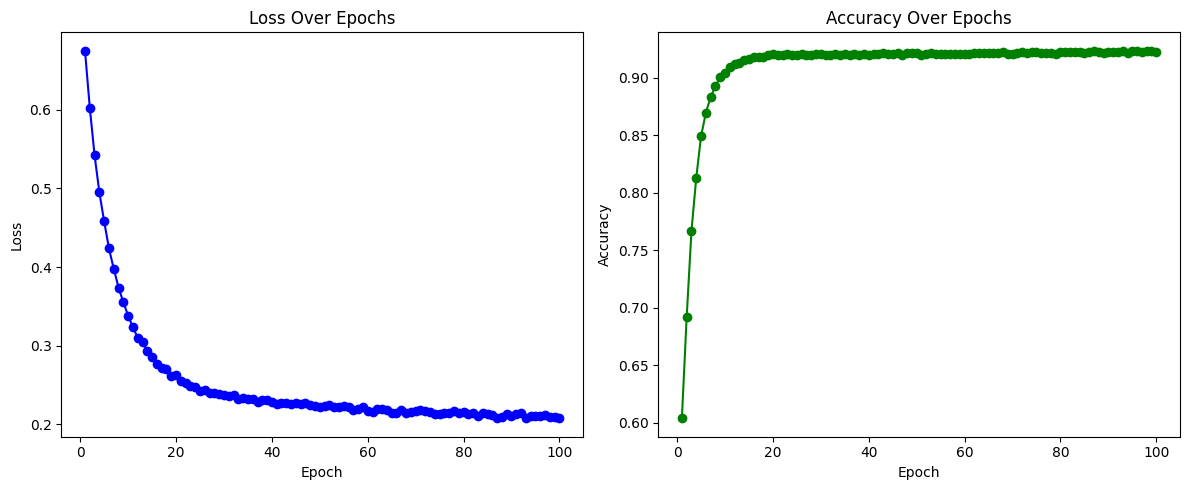

In [16]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), losses, marker='o', color='b')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, marker='o', color='g')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import accuracy_score
# Evaluate the final model
sincnet.eval()
with torch.no_grad():
    outputs_test = sincnet(encoded_features_test)
    _, predicted_test = torch.max(outputs_test, 1)
    accuracy_test = accuracy_score(labels_test.numpy(), predicted_test.numpy())
    print(f'Final Model Accuracy: {accuracy_test:.4f}')

Final Model Accuracy: 0.9256


In [20]:
# pretrain
pretrain_size = int(0.1 * X_train_extra.shape[0])  # 10% of the training data

X_train_pretrain = X_train_extra[:pretrain_size]
Y_train_pretrain = Y_train_extra[:pretrain_size]

# fine-tuning
X_train_extra = X_train_extra[pretrain_size:]
Y_train_extra = Y_train_extra[pretrain_size:]

In [21]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense').output)

encoded_features_pretrain = encoder.predict(X_train_pretrain)
encoded_features = encoder.predict(X_train_extra)
encoded_features_test = encoder.predict(X_test_extra)

encoded_features_pretrain = torch.tensor(encoded_features_pretrain).float()
encoded_features = torch.tensor(encoded_features).float()
encoded_features_test = torch.tensor(encoded_features_test).float()

labels_pretrain = torch.tensor(Y_train_pretrain).long()
labels = torch.tensor(Y_train_extra).long()
labels_test = torch.tensor(Y_test_extra).long()

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [22]:
import torch.nn as nn

class SincConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(SincConv, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)

    def forward(self, x):
        x = self.conv(x)
        return x

class SincNet(nn.Module):
    def __init__(self, input_dim, num_classes=2, dropout_p=0.6):
        super(SincNet, self).__init__()
        self.sinc_conv = SincConv(in_channels=1, out_channels=64, kernel_size=3)  # Increased number of channels

        self.fc1 = nn.Linear(input_dim * 64, 64)  # Increased dimensions
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_p)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(64)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.sinc_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [23]:
input_dim = encoded_features.shape[1]
sincnet = SincNet(input_dim=input_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(sincnet.parameters(), lr=0.0001)

pretrain_dataset = TensorDataset(encoded_features_pretrain, labels_pretrain)
pretrain_dataloader = DataLoader(pretrain_dataset, batch_size=32, shuffle=True)

train_dataset = TensorDataset(encoded_features, labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

num_pretrain_epochs = 10  # Number of pretraining epochs
num_finetune_epochs = 20  # Number of fine-tuning epochs

In [24]:
print("Pretraining SincNet...")
for epoch in range(num_pretrain_epochs):
    sincnet.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, targets in pretrain_dataloader:
        optimizer.zero_grad()

        outputs = sincnet(inputs)

        loss = criterion(outputs, targets)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_preds += targets.size(0)
        correct_preds += (predicted == targets).sum().item()

    avg_loss = running_loss / len(pretrain_dataloader)
    accuracy = correct_preds / total_preds
    print(f"Pretrain Epoch [{epoch+1}/{num_pretrain_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Pretraining SincNet...
Pretrain Epoch [1/10], Loss: 0.8386, Accuracy: 0.4515
Pretrain Epoch [2/10], Loss: 0.7564, Accuracy: 0.5042
Pretrain Epoch [3/10], Loss: 0.6500, Accuracy: 0.6131
Pretrain Epoch [4/10], Loss: 0.6061, Accuracy: 0.6694
Pretrain Epoch [5/10], Loss: 0.5697, Accuracy: 0.7175
Pretrain Epoch [6/10], Loss: 0.5191, Accuracy: 0.7747
Pretrain Epoch [7/10], Loss: 0.4872, Accuracy: 0.7959
Pretrain Epoch [8/10], Loss: 0.4486, Accuracy: 0.8236
Pretrain Epoch [9/10], Loss: 0.4095, Accuracy: 0.8624
Pretrain Epoch [10/10], Loss: 0.4086, Accuracy: 0.8504


In [25]:
print("Fine-tuning SincNet...")
losses = []
accuracies = []
for epoch in range(num_finetune_epochs):
    sincnet.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, targets in train_dataloader:
        optimizer.zero_grad()

        outputs = sincnet(inputs)

        loss = criterion(outputs, targets)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_preds += targets.size(0)
        correct_preds += (predicted == targets).sum().item()

    avg_loss = running_loss / len(train_dataloader)
    accuracy = correct_preds / total_preds
    losses.append(avg_loss)
    accuracies.append(accuracy)

    print(f"Fine-tune Epoch [{epoch+1}/{num_finetune_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Fine-tuning SincNet...
Fine-tune Epoch [1/20], Loss: 0.3709, Accuracy: 0.8938
Fine-tune Epoch [2/20], Loss: 0.3073, Accuracy: 0.9148
Fine-tune Epoch [3/20], Loss: 0.2796, Accuracy: 0.9179
Fine-tune Epoch [4/20], Loss: 0.2772, Accuracy: 0.9196
Fine-tune Epoch [5/20], Loss: 0.2683, Accuracy: 0.9200
Fine-tune Epoch [6/20], Loss: 0.2645, Accuracy: 0.9207
Fine-tune Epoch [7/20], Loss: 0.2555, Accuracy: 0.9202
Fine-tune Epoch [8/20], Loss: 0.2529, Accuracy: 0.9205
Fine-tune Epoch [9/20], Loss: 0.2524, Accuracy: 0.9202
Fine-tune Epoch [10/20], Loss: 0.2516, Accuracy: 0.9205
Fine-tune Epoch [11/20], Loss: 0.2470, Accuracy: 0.9204
Fine-tune Epoch [12/20], Loss: 0.2430, Accuracy: 0.9205
Fine-tune Epoch [13/20], Loss: 0.2464, Accuracy: 0.9204
Fine-tune Epoch [14/20], Loss: 0.2431, Accuracy: 0.9209
Fine-tune Epoch [15/20], Loss: 0.2423, Accuracy: 0.9207
Fine-tune Epoch [16/20], Loss: 0.2372, Accuracy: 0.9203
Fine-tune Epoch [17/20], Loss: 0.2352, Accuracy: 0.9207
Fine-tune Epoch [18/20], Loss: 0.2

In [26]:
# Evaluate final model
sincnet.eval()
with torch.no_grad():
    outputs_test = sincnet(encoded_features_test)
    _, predicted_test = torch.max(outputs_test, 1)
    accuracy_test = accuracy_score(labels_test.numpy(), predicted_test.numpy())
    print(f'Final Model Accuracy: {accuracy_test:.4f}')

Final Model Accuracy: 0.9256


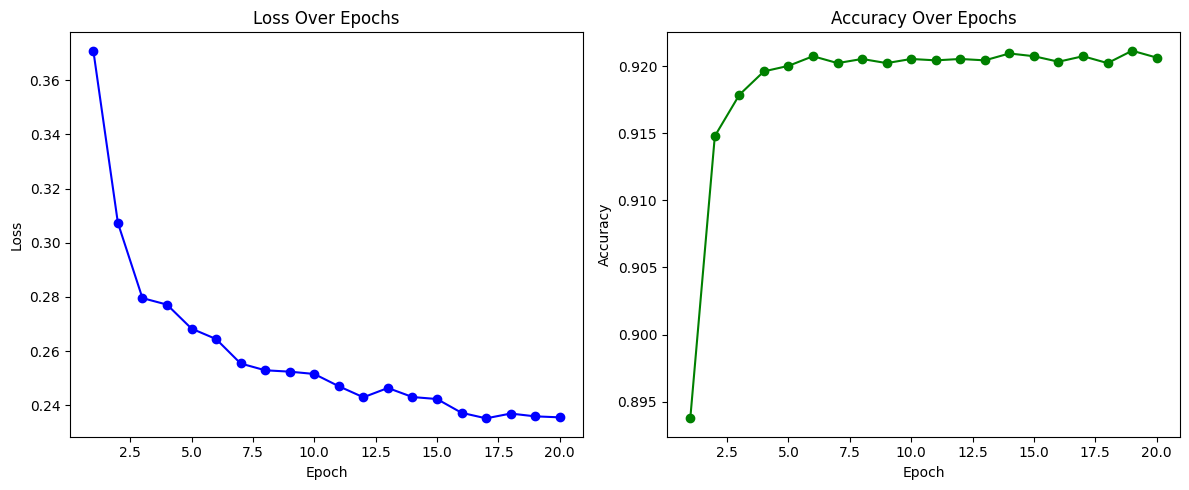

In [27]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_finetune_epochs + 1), losses, marker='o', color='b')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_finetune_epochs + 1), accuracies, marker='o', color='g')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()